# Part 2: Real credit risk data
### By: Gokhan Arkan & Juan Diaz

The cell below imports the required libraries and both testing and training data needed for the models.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

train_data = pd.read_csv('creditdefault_train.csv', header='infer')
test_data = pd.read_csv('creditdefault_test.csv', header='infer')

#### Preparation of dummy data

Some features of the training and testing sets are treated as numerical features, but they are categorical. For example, the education field (X3) has range 1 - 4, but each value can be a separate binary feature.


In [10]:
'''
  DATA PREPARATION MAIN FUNCTION
  This function works for both Training and Testing data as they both have the same features
  It requires the set to be prepare and returns the final set
'''
def data_preparation(dataset):

  # X3: Education field is divided in 3 binary features, last one is implicit when all three features are equal to 0
  dataset['graduated'] = (dataset['X3'] == 1).astype('int')
  dataset['university'] = (dataset['X3'] == 2).astype('int')
  dataset['high_school'] = (dataset['X3'] == 3).astype('int')
  dataset.drop('X3', axis=1, inplace=True)

  # X2: Gender field is binary as well. Male = 1 and Female = 0
  dataset['male'] = (dataset['X2'] == 1).astype('int')
  dataset.drop('X2', axis=1, inplace=True)

  # X4: Married field is also binary. Married = 1 and Single = 0
  dataset['married'] = (dataset['X4'] == 1).astype('int')
  dataset.drop('X4', axis=1, inplace=True)

  # X6 - X11: History of past payments. All values less than 0 are converted to 0 meaning they are not delayed on payments
  are_paid = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11']
  for column in are_paid:
    dataset.loc[dataset[column] <= 0, column] = 0

  # Return the modified dataset
  return dataset


# Call for preparation of the data using the main function
train_data = data_preparation(train_data)
test_data = data_preparation(test_data)


# Separate classes from dataset for training and testing
y_train = train_data['Y']
X_train = train_data.drop(['Y'],axis=1)

y_test = test_data['Y']
X_test = test_data.drop(['Y'],axis=1)


'''
  Use RobustScaler preprocessor to convert the data to the same scale 
  as certain features like `age` have a larger scale.
'''
from sklearn.preprocessing import RobustScaler

X_train = RobustScaler().fit_transform(X_train)
X_test = RobustScaler().fit_transform(X_test)

#### Cross Validation

It evaluates all six algorithms using cross validation and plot them in a table to analize their accuracy and standard deviation.

In [11]:
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Prepare the data frame for visualizing the cross validation
crossvalidator = pd.DataFrame(index=['Accuracy', 'Standard Deviation'], columns=[])

# Function to populate the evaluation of each model
def eval_crossval(model_name, crossval):
  crossvalidator.loc['Accuracy', model_name] = crossval['test_score'].mean()
  crossvalidator.loc['Standard Deviation', model_name] = crossval['test_score'].std() * 2


# Compute cross validation for KNN
knn = KNeighborsClassifier()
crossknn = cross_validate(knn, X_train, y_train, cv=5)
eval_crossval("KNN", crossknn)

# Compute cross validation for Decision Tree
dtc = DecisionTreeClassifier()
crossdtc = cross_validate(dtc, X_train, y_train, cv=5)
eval_crossval("Decision Tree", crossdtc)

# Compute cross validation for Bagging Accuracy
bag = BaggingClassifier()
crossbag = cross_validate(bag, X_train, y_train, cv=5)
eval_crossval("Bagging Accuracy", crossbag)

# Compute cross validation for Ada Boost
abc = AdaBoostClassifier()
crossabc = cross_validate(abc, X_train, y_train, cv=5)
eval_crossval("Ada Boost", crossabc)

# Compute cross validation for Random Forest
rfc = RandomForestClassifier()
crossrfc = cross_validate(rfc, X_train, y_train, cv=5)
eval_crossval("Random Forest", crossrfc)

# Compute cross validation for SVC
svc = SVC()
crosssvc = cross_validate(svc, X_train, y_train, cv=5)
eval_crossval("SVC", crosssvc)


# Display table of cross validation
crossvalidator

,KNN,Decision Tree,Bagging Accuracy,Ada Boost,Random Forest,SVC
Accuracy,0.791733,0.728200,0.807333,0.818467,0.815933,0.816133
Standard Deviation,0.013289,0.016114,0.017430,0.017495,0.018825,0.013918


#### Cross Validation analysis

According to the cross-validation table above, the algorithm with higher performance is Ada Boost. However, all the other algorithms are very close to it, except the Decision Tree. Since AdaBoost and Bagging use an implementation of Decision Trees in the first place, it gives a better precision for the data. In the end, these two ensemble algorithms worked better than the other ones. On the other hand, although SVC gave accurate prediction, since the nature of the algorithm, we expect more computation time compared to the other algorithms.

#### Helper functions for visualizing data
They will be use several times for plotting graphs or displaying tables.

In [14]:
# Prepare the data frame for visualizing the final models evaluations
evaluator = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall'], columns=[])


# Function to populate the evaluation of each model 
def eval_module(model_name, y_truth, y_pred):
  evaluator.loc['Accuracy', model_name] = accuracy_score(y_truth, y_pred)
  evaluator.loc['Precision', model_name] = precision_score(y_truth, y_pred)
  evaluator.loc['Recall', model_name] = recall_score(y_truth, y_pred)


# Function to visualize the evaluation of all models
def visual_evaluation(evaluation):
  fig, ax = plt.subplots(figsize=(8,5))
  evaluation.plot(kind='barh', ax=ax)
  ax.grid()


# Function to print the confusion matrix of a given module
def print_conf_matrix(cm):
  labels = ['Payers', 'Defaulters']
  conf = pd.DataFrame(data=cm, index=labels, columns=labels)
  conf.index.name = "TRUE"
  conf.columns.name = "PREDICTION"
  conf.loc['Total'] = conf.sum()
  conf['Total'] = conf.sum(axis=1)
  return conf

#### Helper functions for manipulating data
The functions here are used for calculations in the code of certain models.

In [15]:
# This function takes a dictionary with indexes and accuracies and finds the highest and returns it. Use for KNN, Adaboost and Bagging
def find_best_param(accuracy_dict):
    largest, index = 0, 0

    # Loop the dictionary
    for i in accuracy_dict:

        # This iteration is higher than previous ones
        if largest < accuracy_dict[i]:
            largest = accuracy_dict[i]
            index = i
            
    # Return index and its best accuracy
    return (index, largest)

### KNN Classifier algorithm
This implementation finds the best K in a range of 1 to 9, store their performance and print the confusion matrix of the model.

In [16]:
# KNN for K = 1 to 9
from sklearn.neighbors import KNeighborsClassifier

scores_knn = {}
total_k = 9 # Calculate distances for K = 1 to 9

# Train data K times
for k in range(1, total_k + 1):

    # Initialize KNN for k neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)

    # Predict classes and store the accuracy 
    y_pred = knn.predict(X_test)
    scores_knn[k] = accuracy_score(y_test, y_pred)

# Find the best K using the helper function
best_k = find_best_param(scores_knn)

print('Best accuracy at K =', best_k[0], 'of %.3f' % best_k[1])  

# Compute the final KNN with the best K achieved
knn_best_k = KNeighborsClassifier(n_neighbors = best_k[0])
knn_best_k.fit(X_train, y_train)

# Best predictor found
y_pred_best = knn_best_k.predict(X_test)

# Evaluation of this module
eval_module("KNN", y_test, y_pred_best)

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)

Best accuracy at K = 9 of 0.806


PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,10987,695,11682
Defaulters,2213,1105,3318
Total,13200,1800,15000


### Decision Tree Classifier algorithm
This implementation computes and print the confusion matrix of Decision Tree.

In [17]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation of this module
eval_module("DecisionTree", y_test, y_pred)

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)

PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,10604,1078,11682
Defaulters,2255,1063,3318
Total,12859,2141,15000


### Random Forest Classifier
This implementation uses the Random Forest algorithm fitting with 500 base classifiers, sends the prediction accuracy to the evaluation methods and print the confusion matrix.

In [14]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

# 500 base classifiers fit to the 2-dimensional dataset
numBaseClassifiers = 500

# Initialize the Random Forest Classfier and fit the data to the model
rf = RandomForestClassifier(n_estimators=numBaseClassifiers)
rf.fit(X_train, y_train)

# Predict classes and store the accuracy 
y_pred = rf.predict(X_test)

# Evaluation of this model
eval_module("Random Forest", y_test, y_pred)

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)


PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,11086,596,11682
Defaulters,2163,1155,3318
Total,13249,1751,15000


### Bagging Classifier
This implementation uses the Bagging algorithm along with Decision Trees, fitting with 500 base classifiers. It also iterates a list of max depth values and gets the best one. With the best picked depth, the model recalculates and sends the prediction data to evaluation. At the end it prints the confusion matrix.

In [15]:
# Bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 500 base classifiers fit to the 2-dimensional dataset
numBaseClassifiers = 500

# Checking different sizes of max depth
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

# Keeping the individual max depth scores in a dictionary to get best one
scores_bagging = {}

for depth in maxdepths:

  # Initialize the Bagging Classifier and fit the data to the model
  bg = BaggingClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=numBaseClassifiers)
  bg.fit(X_train, y_train)

  # Predict classes and store the accuracy
  y_pred = bg.predict(X_test)

  # Putting the accuracy score to the dictionary
  scores_bagging[depth] = accuracy_score(y_test, y_pred)

best_depth = find_best_param(scores_bagging)
bagging_best_depth = BaggingClassifier(DecisionTreeClassifier(max_depth=best_depth[0]),n_estimators=numBaseClassifiers)

bagging_best_depth.fit(X_train, y_train)
y_pred_best = bagging_best_depth.predict(X_test)

# Evaluation of this model
eval_module("Bagging", y_test, y_pred_best)

print('Best depth is at =', best_depth[0], 'of %.3f' % best_depth[1])

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)

Best depth is at = 8 of 0.818


PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,11119,563,11682
Defaulters,2172,1146,3318
Total,13291,1709,15000


### AdaBoost Classifier
This implementation uses the AdaBoost algorithm along with Decision Trees, fitting with 500 base classifiers. It also iterates a list of max depth values and gets the best one. With the best picked depth, the model recalculates and sends the prediction data to evaluation. At the end it prints the confusion matrix.

In [18]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 500 base classifiers fit to the 2-dimensional dataset
numBaseClassifiers = 500

# Checking different sizes of max depth
# maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
maxdepths = [10]

# Keeping the individual max depth scores in a dictionary to get best one
scores_adaboost = {}

for depth in maxdepths:
  # Initialize the AdaBoost Classifier and fit the data to the model
  ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=numBaseClassifiers)
  ab.fit(X_train, y_train)

  # Predict classes and store the accuracy
  y_pred = ab.predict(X_test)

  # Putting the accuracy score to the dictionary
  scores_adaboost[depth] = accuracy_score(y_test, y_pred)

best_depth = find_best_param(scores_adaboost)
adaboost_best_depth = AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth[0]),n_estimators=numBaseClassifiers)

adaboost_best_depth.fit(X_train, y_train)
y_pred_best = adaboost_best_depth.predict(X_test)

eval_module("AdaBoost", y_test, y_pred_best)
print('Best depth is at =', best_depth[0], 'of %.3f' % best_depth[1])

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)

Best depth is at = 10 of 0.794


PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,10831,851,11682
Defaulters,2235,1083,3318
Total,13066,1934,15000


### SVM
This implementation uses Linear SVM approach with a list of C parameters. It iterates through every parameter and pick the best one. With the best parameter, the implementation calculates the prediction accuracy and sends the evaluation methods. At the end, it prints a confusion matrix.


In [10]:
# SVM

from sklearn import linear_model
from sklearn.svm import SVC

# Hyerparameter that controls the inverse of model complexity
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]

# Keeping the individual hypeparameter scores in a dictionary to get best one
scores_svm = {}

for param in C:

  # Initialize the SVM Classifier and fit the data to the model
  svclassifier = SVC(kernel='linear', C=param)
  svclassifier.fit(X_train, y_train)

  # Predict classes and store the accuracy
  y_pred = svclassifier.predict(X_test)

  # Putting the accuracy score to the dictionary
  scores_svm[param] = accuracy_score(y_test, y_pred)

best_param = find_best_param(scores_svm)
svm_best_param = SVC(kernel='linear', C=best_param[0])

svm_best_param.fit(X_train, y_train)
y_pred_best = svm_best_param.predict(X_test)

eval_module("SVM", y_test, y_pred_best)
print('Best param is at =', best_param[0], 'of %.3f' % best_param[1])

# Print the confusion matrix of this model
con_matrix = confusion_matrix(y_test, y_pred)
print_conf_matrix(con_matrix)

Best param is at = 1 of 0.817


PREDICTION,Payers,Defaulters,Total
TRUE,,,
Payers,11007,675,11682
Defaulters,2064,1254,3318
Total,13071,1929,15000


,AdaBoost,SVM,KNN,DecisionTree,Random Forest,Bagging
Accuracy,79.020000,81.740000,80.613333,77.780000,81.606667,81.826667
Precision,54.516640,65.007776,61.388889,49.649696,65.962307,67.411765
Recall,31.103074,37.793852,33.303195,32.037372,34.810127,34.538879


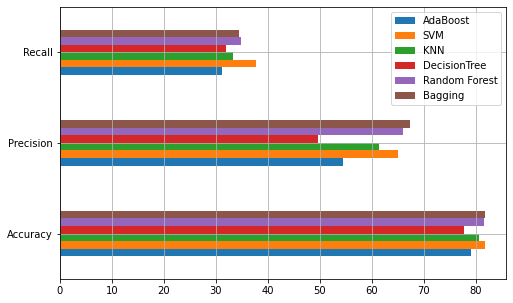

In [19]:
visual_evaluation(evaluator*100)

100*evaluator

#### Final evaluation
This graph illustrates the performance of all the algorithms using the test data. The primary three keys to evaluate are:
- Accuracy: How the model predicted correct and incorrect defaulters
- Precision: How often the model predicted someone is a defaulter correctly
- Recall: Proportion of actual defaulters that the model predicted

In order to choose the metrics, we need to consider which mistakes to avoid. 
In this project, the most appropriate metric to look at is Recall to catch the False Negative who are the defaulters that were predicted as payers

SVM performance is generally one of the best choices but especially its Recall the most beneficial for the data.